In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


## Simple EDA of Team-Level Data
With event-level data already explored, the next layer of abstraction to explore is player-level information contained in the file 'teamstats_2017-2018_2018-2019.csv', which contains team-level aggregate information by unique game_id. Note that there are two records for each unique game_id, one for each team competing against each other 
- This short notebook serves to explore simple approaches similar to those existing to predict match outcome as a benchmark against which future models will be compared

In [76]:
# Once again, loading selected relevant datasets, this time for teams
# plays = pd.read_csv('plays_2017-2018_2018-2019.csv')
# games = pd.read_csv('games_2017-2018_2018-2019.csv')
# skater_stats = pd.read_csv('skaterstats_2017-2018_2018-2019.csv')
team_stats = pd.read_csv('teamstats_2017-2018_2018-2019.csv')
# s_info = pd.read_csv('player_info.csv') # static library of players
t_info = pd.read_csv('team_info.csv') # static library of teams

In [77]:
team_stats = team_stats.merge(t_info,on='team_id') # merge with team metadata
team_stats.columns

Index(['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'franchiseId',
       'shortName', 'teamName', 'abbreviation', 'link'],
      dtype='object')

Here we can clearly see the different categorical and numeric variables contained in each record. We want to use these to predict game outcome. For simplicity, let's consider a binary classification problem, where we only care about the 'won' column, and not whether or not the match was settled in regulation ('REG'), or overtime ('OT') 

In [78]:
team_stats.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,franchiseId,shortName,teamName,abbreviation,link
0,2017030241,28,away,False,REG,Peter DeBoer,0,33,33,31,5,0,47.8,8,6,29,San Jose,Sharks,SJS,/api/v1/teams/28
1,2017030242,28,away,True,OT,Peter DeBoer,4,47,48,12,7,2,55.1,7,12,29,San Jose,Sharks,SJS,/api/v1/teams/28
2,2017030243,28,home,False,OT,Peter DeBoer,3,42,44,12,4,1,57.7,13,14,29,San Jose,Sharks,SJS,/api/v1/teams/28
3,2017030244,28,home,True,REG,Peter DeBoer,4,34,31,22,5,1,55.7,4,7,29,San Jose,Sharks,SJS,/api/v1/teams/28
4,2017030245,28,away,False,REG,Peter DeBoer,3,30,35,20,4,1,49.3,7,4,29,San Jose,Sharks,SJS,/api/v1/teams/28


Like player-level and event-driven data previously explored, this dataset could be explored in a similar fashion, but we are interested in better understanding the contributing factors to the match result. So, let's condense the existing dataset by selecting some features to construct a simple Logistic Regression model

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
team_stats['turnovers']=team_stats['takeaways']-team_stats['giveaways']
features = team_stats[['goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'turnovers']] # our features to train on
results = team_stats[['won']] # our target

x_train,x_test,y_train,y_test = train_test_split(features,results,test_size=0.3) # validate on 30% of dataset 
lr_clf = LogisticRegression()
lr_clf.fit(x_train,y_train)

LogisticRegression()

In [80]:
pred = lr_clf.predict(x_test)
accuracy_score(y_test,pred)

0.7868550368550369

In [81]:
# Let's create a confusion matrix for this model
confusion_matrix(y_test,pred)

array([[618, 178],
       [169, 663]], dtype=int64)

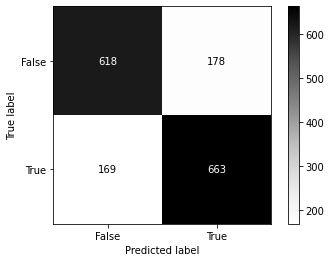

In [82]:
plot_confusion_matrix(lr_clf,x_test,y_test,cmap=plt.cm.Greys)

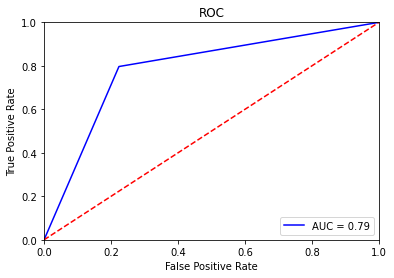

In [83]:
#TODO: Plot ROC - DONE
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So, this simple Logistic Regression model performs really well, with an accuracy of over 77%! Why is this the case? GOALS and powerplay GOALS were included in the feature space! Common sense would dictate that knowing the number of goals a team scores would yield a good indication as to whether they would win the game or not. We want to predict the match outcome without this knowledge, because the only insight this provides is "If a team wants to win more games, they should simply score more goals". 

So, let's see what happens if we remove goals and powerplay goals from the feature space to assess the relationships between other team-level metrics and match result

In [84]:
better_features = team_stats[['shots', 'hits', 'pim', 'powerPlayOpportunities', 'faceOffWinPercentage', 'turnovers']] # our features to train on
results2 = team_stats[['won']] # our target

x_train2,x_test2,y_train2,y_test2 = train_test_split(better_features,results2,test_size=0.3) # validate on 30% of dataset 
lr_clf2 = LogisticRegression()
lr_clf2.fit(x_train2,y_train2)
pred2 = lr_clf2.predict(x_test2)
accuracy_score(y_test2,pred2)

0.5472972972972973

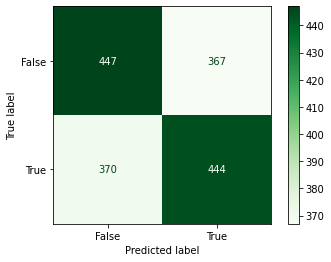

In [85]:
plot_confusion_matrix(lr_clf2,x_test2,y_test2,cmap=plt.cm.Greens)

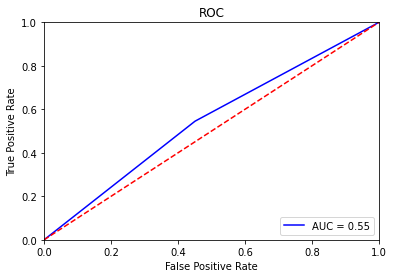

In [86]:
fpr2, tpr2, threshold2 = roc_curve(y_test2, pred2)
roc_auc2 = auc(fpr2, tpr2)
plt.title('ROC')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This verifies the obvious assumption that goal-related information will have a great effect on the outcome of a match, and accuracy suffers when it's removed. This reinforces the motivating cause for this project, where even the best models are said to be not much better than 60% accurate, and this simple model is not much better than a coin flip (from the ROC curve)
- Moving forward, the objective is to create a denser feature space using the previously explored datasets (and potentially other sources mentioned in the proposal document) to create a more sophisticated model focused on improving this accuracy. 
- The objective is to predict the match outcome, so it would be prudent to include features that are available, and representative of each team before the game has started, which could synergize well with the events that take place over the course of the game to predict the outcome